In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime, os

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
print(tf.__version__)

2.3.0


In [5]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [6]:
#Carga de datos
data = np.load("./proyecto_data/proyecto_training_data.npy")

In [7]:
logs_path = "./logs/graph_"

In [8]:
#Carga de datos
data = np.load("./proyecto_data/proyecto_training_data.npy")
data_df = pd.DataFrame(data, columns=["SalePrice", "OvrllQual", "1stFlrSF", "TotRmAbvGrd", "YearBuilt" ,"LotFrontage"], dtype='float32')
data_df = data_df.astype('float32')

np.random.seed(101)
tf.set_random_seed(101)

x, y = data_df.iloc[:,1:], data_df.loc[:,["SalePrice"]]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)
data_df["OvrllQual"].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OvrllQual, dtype: float64

In [9]:
print(train_y)
print(f"Sale Price Null Values: {train_y['SalePrice'].isnull().sum()}")
print(f"OvrllQual Null values: {train_x['OvrllQual'].isnull().sum()}")
print(f"1stFlrSF Null values: {train_x['1stFlrSF'].isnull().sum()}")
print(f"TotRmAbvGrd Null values: {train_x['TotRmAbvGrd'].isnull().sum()}")
print(f"YearBuilt Null values: {train_x['YearBuilt'].isnull().sum()}")
print(f"LotFrontage Null values: {train_x['LotFrontage'].isnull().sum()}")

      SalePrice
1312   302000.0
1408   125500.0
1165   233170.0
1346   262500.0
399    241000.0
...         ...
1417   340000.0
75      91000.0
599    151000.0
1361   260000.0
863    132500.0

[1022 rows x 1 columns]
Sale Price Null Values: 0
OvrllQual Null values: 0
1stFlrSF Null values: 0
TotRmAbvGrd Null values: 0
YearBuilt Null values: 0
LotFrontage Null values: 184


In [10]:
# La funcion describe nos presenta ciertas metricas estadisticas descriptivas. 
train_x.describe()

,OvrllQual,1stFlrSF,TotRmAbvGrd,YearBuilt,LotFrontage
count,1022.000000,1022.000000,1022.000000,1022.000000,838.000000
mean,6.113503,1165.537231,6.502935,1972.066528,70.400955
std,1.373755,375.758789,1.615756,29.648966,24.111233
min,1.000000,372.000000,3.000000,1872.000000,21.000000
25%,5.000000,892.000000,5.000000,1954.000000,59.000000
50%,6.000000,1096.500000,6.000000,1974.000000,70.000000
75%,7.000000,1381.000000,7.000000,2001.000000,80.000000
max,10.000000,3228.000000,14.000000,2010.000000,313.000000


In [11]:
train_y.describe()

,SalePrice
count,1022.000000
mean,181608.593750
std,79481.921875
min,37900.000000
25%,129500.000000
50%,164250.000000
75%,215000.000000
max,745000.000000


Text(0.5, 1.0, 'OvrllQual vs SalePrice Correlacion = 0.80')

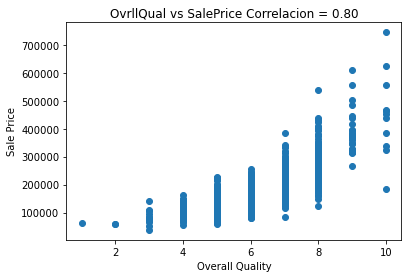

In [12]:
fig, axs = plt.subplots(1,1)
p = train_y['SalePrice'].corr(train_x['OvrllQual'], method='pearson')
title = f"OvrllQual vs SalePrice Correlacion = {p:.2f}"
axs.scatter(train_x['OvrllQual'], train_y)
axs.set_xlabel("Overall Quality")
axs.set_ylabel("Sale Price")
axs.set_title(title)

Función de costo MSE

$J(g) = (1/2)g^2$

$g(h) = h - y$

$h(w_1) = w_1x$



In [13]:
def compute_prediction(X, params):
    ## add a column of one's to add the bias (b) in the same vectorize operation
    with tf.name_scope("Model"):
        padding = tf.constant([[0,0],[1, 0]], name="Padding")
        X_with_bias = tf.pad(X, padding, "CONSTANT", constant_values=1, name="PreparedData")
        model = tf.linalg.matmul(X_with_bias, params, name="Predict")
    return model

def compute_mse(y, y_hat):
    with tf.name_scope("Cost"):
        diff = tf.math.square(tf.math.subtract(y, y_hat))
        mse = 0.5 * tf.reduce_mean(diff, name="MSE")
        mse_summary = tf.summary.scalar(name="MSE_Summary", tensor=mse)
    return mse, mse_summary

def build_linear_model_graph(tensor_x, tensor_y, params, lr=0.001):
    prediction = compute_prediction(tensor_x, params)
    mse, mse_summary = compute_mse(tensor_y, prediction)
    with tf.name_scope("GradieDescent"):
        gradient = tf.gradients(mse, [params], name="Gradient")
        update_params = tf.assign(params, params - lr * gradient[0], name="UpdateParams")
    return prediction, update_params, params, mse, mse_summary

def fit(X, Y, batch_size, epochs=100, lr=0.001, print_n=10):
    tf.reset_default_graph()
    params = tf.get_variable("Params", dtype=tf.float32, shape=[2, 1],initializer=tf.zeros_initializer())
    tensor_x = tf.placeholder(tf.float32, [None,1], name="X")
    tensor_y = tf.placeholder(tf.float32, [None,1], name="Y")
    get_prediction, update_params, params, mse, mse_summary = build_linear_model_graph(tensor_x, tensor_y, params, lr)
    n = X.shape[0] // batch_size
    final_tetha = None
    path = f"{logs_path}batch_size_{batch_size}_lr_{lr}_{datetime.today().strftime('%Y%m%d-%H%M%S')}"
    with tf.train.MonitoredSession() as session:
        with tf.summary.FileWriter(path, session.graph) as train_writer:
            for epoch in range(epochs): 
                for i in range(n):
                    start, end = i * batch_size, (i+1) * batch_size
                    x_mbatch = np.array(X[start:end,]).reshape(-1,1)
                    y_mbatch = np.array(Y[start:end]).reshape(-1,1)
                    feed_dict = { tensor_x: x_mbatch, tensor_y: y_mbatch}
                    _, theta = session.run([update_params, params], feed_dict=feed_dict)
                if (epoch + 1) % print_n == 0:
                    feed_dict = { tensor_x: np.array(X).reshape(-1,1), tensor_y: np.array(Y).reshape(-1,1) }
                    e_summary, error =  session.run([mse_summary, mse], feed_dict = feed_dict)
                    train_writer.add_summary(e_summary, epoch)
            final_theta = session.run(params, feed_dict=feed_dict)
    def predict(x): 
        return compute_prediction(x, params)
    return final_theta, predict

<img src="https://github.com/mazg-95/statistical-learning/blob/main/Tarea1/images/graph.PNG?raw=true">

### Hipotesis: BatchSize = 10, Learning Rate = 0.001, epochs = 1000

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


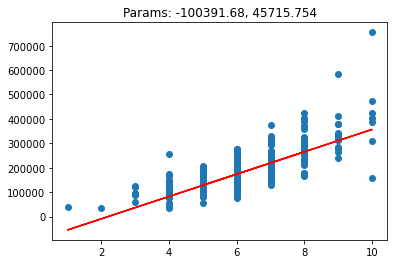

In [14]:
%tensorboard --logdir logs
x_train, y_train = train_x["OvrllQual"], train_y["SalePrice"]
x_test, y_test = test_x["OvrllQual"], test_y["SalePrice"]
plt.scatter(x_test, y_test)
theta, predict = fit(x_train, y_train, batch_size=10, epochs=1000, lr=0.001, print_n=20)
with tf.Session() as session:
    y_estimates = session.run(compute_prediction(np.array(x_test).reshape(-1,1).astype('float32'), theta))
    plt.plot(x_test, y_estimates, color='r')
    plt.title(f"Params: {', '.join(map(str, theta.reshape(-1,)))}")
    plt.show()


### Hipotesis: BatchSize = 32, Learning Rate = 0.001, epochs = 1000

Reusing TensorBoard on port 6006 (pid 19600), started 0:00:45 ago. (Use '!kill 19600' to kill it.)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


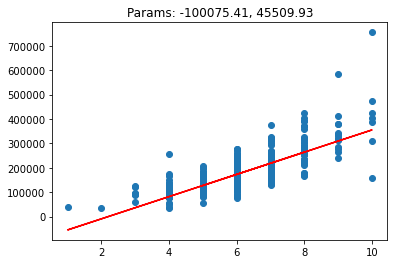

In [15]:
%tensorboard --logdir logs
x_train, y_train = train_x["OvrllQual"], train_y["SalePrice"]
x_test, y_test = test_x["OvrllQual"], test_y["SalePrice"]
plt.scatter(x_test, y_test)
theta, predict = fit(x_train, y_train, batch_size=16, epochs=1000, lr=0.002, print_n=20)
with tf.Session() as session:
    y_estimates = session.run(compute_prediction(np.array(x_test).reshape(-1,1).astype('float32'), theta))
    plt.plot(x_test, y_estimates, color='r')
    plt.title(f"Params: {', '.join(map(str, theta.reshape(-1,)))}")
    plt.show()

### Conclusion

Segun los resultados vistos en Tensorflow con un Batch Size de 32 podriamos reducir el MSE del modelo con los datos de entrenamiento. Y con un batch_size mas pequeño, esto significaria un mayor numero de iteraciones sobre el dataset de entrenamiento. Podemos ver que el modelo no mejora drasticamente agregando mas de 4000 epochs.

<img src="https://github.com/mazg-95/statistical-learning/blob/main/Tarea1/images/Scalars.png?raw=true">